# 9. Downlink Data Communication in 5G Networks

In this project we will demonstrate the transmission and reception of the data from base-station (BS) using low cost SDRs. The whole simulation consists of two parts:

**Transmitter side**:

1. Generate the SSB block
2. Generate the transport block ==> Process it with PDSCH chain ==> Create the slot resource grids
3. Generate the resource grid and load SSB + PDSCH both into it.
4. Pass the resource grid through the OFDM modulator: Generate the time domain I/Q samples.
5. Pass it to the SDR and radiate the signal to the medium.

**Receiver side**:

1. Sample the medium to receive the samples and store thm in the buffer.
2. Downlink synchronization
    - This is performed using synchronization signal block (SSB).
    - Helps with 
        - time/frame synchronization.
        - Coarse CFO correction.
        - Cell ID detection.
        - Decoding MIB information.
3. Data transmission and decoding
    - 

![SSB Transmitter](images/Procedure.png)

## 9. Import Python Libraries

In [1]:
%matplotlib widget

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation

import numpy as np
import adi

# from IPython.display import display, HTML
# display(HTML("<style>.container { width:98% !important; }</style>"))

## 9. 5G Toolkit Libraries

In [2]:
import sys
sys.path.append("../../../../")

from toolkit5G.SequenceGeneration import PSS, SSS, DMRS
from toolkit5G.PhysicalChannels   import PBCH
from toolkit5G.ResourceMapping    import SSB_Grid, ResourceMapperSSB
from toolkit5G.OFDM               import OFDMModulator
from toolkit5G.MIMOProcessing     import AnalogBeamforming
from toolkit5G.Configurations     import TimeFrequency5GParameters, GenerateValidSSBParameters

from toolkit5G.SequenceGeneration import PSS, SSS, DMRS
from toolkit5G.PhysicalChannels   import PBCH, PBCHDecoder
from toolkit5G.ResourceMapping    import SSB_Grid, ResourceMapperSSB
from toolkit5G.OFDM               import OFDMModulator, OFDMDemodulator
from toolkit5G.MIMOProcessing     import AnalogBeamforming, ReceiveCombining
from toolkit5G.ReceiverAlgorithms import PSSDetection, SSSDetection, ChannelEstimationAndEqualization, DMRSParameterDetection
from toolkit5G.Configurations     import TimeFrequency5GParameters, GenerateValidSSBParameters


from toolkit5G.PhysicalChannels.PDSCH import ComputeTransportBlockSize
from toolkit5G.PhysicalChannels       import PDSCHLowerPhy, PDSCHUpperPhy, PDSCHDecoderLowerPhy, PDSCHDecoderUpperPhy
from toolkit5G.Configurations         import PDSCHLowerPhyConfiguration, PDSCHUpperPhyConfiguration
from toolkit5G.SymbolMapping          import Mapper, Demapper
from toolkit5G.Scrambler              import DeScrambler, Scrambler
from toolkit5G.SymbolMapping          import Demapper
from toolkit5G.PhysicalChannels.PDSCH import LayerDemapper

from toolkit5G.PhysicalChannels   import PBCHDecoder
from toolkit5G.OFDM               import OFDMDemodulator
from toolkit5G.ReceiverAlgorithms import PSSDetection, SSSDetection, ChannelEstimationAndEqualizationPBCH, DMRSParameterDetection, CarrierFrequencyOffsetEstimation, ChannelEstimationAndEqualizationPDSCH

from toolkit5G.PhysicalChannels       import PDSCHLowerPhy, PDSCHUpperPhy, PDSCHDecoderLowerPhy, PDSCHDecoderUpperPhy


## 9. Emulation Parameters

In [3]:
# Carrier Frequency
carrierFrequency = 1*10**9
numBatches       = 9        # Number of batches considered for simulation
scs              = 15*10**3   # Subcarrier Spacing for simulation
numBSs           = 1          # Number of BSs considered for simulation
bandwidth        = 30*10**6

# Number of UEs considered for simulation
numUEs           = numBatches # For now we are assuming that the numbatches are captured via numUEs
numRB            = 170         # Number of Resource mapping considered for simulation | # 1 RB = 12 subcarrier
slotNumber       = int(np.random.randint(0,2**(scs/15000)*10)) # Index of the slot considered for simulation
Nfft             = 2048       # FFTSize

Nt               = 1

print("************ Simulation Parameters *************")
print()
print("     numBatches: "+str(numBatches))
print("          numRB: "+str(numRB))
print("       fft Size: "+str(Nfft))
print("         numBSs: "+str(numBSs))
print("         numUEs: "+str(numUEs))
print("            scs: "+str(scs))
print("     slotNumber: "+str(slotNumber))
print("Num of Antennas: "+str(Nt))
print()
print("********************************************")

************ Simulation Parameters *************

     numBatches: 9
          numRB: 170
       fft Size: 2048
         numBSs: 1
         numUEs: 9
            scs: 15000
     slotNumber: 7
Num of Antennas: 1

********************************************


## 9. PDSCH Transmitter Implementation

![PDSCH Transmitter](images/PDSCH_Tx.png)

## 9. Generate the PDSCH related parameters: Use PDSCH Configurations

In [4]:
######################################### PDSCH Lower Physical Layer Parameters #########################################
pdschMappingType       = 'PDSCH-mapping-type-B'   # "PDSCH mapping type A" or "PDSCH mapping type B"
maxLength              = 'len1'                   #
startSymbol            = 2                        # 
numSymbols             = 12                       # 
betaDMRS               = 1                        # 0 to 1
configurationType      = "Configuration-type-1"   # "Configuration-type-1" or "Configuration-type-2"
dmrsTypeAPosition      = "pos2"                   # "pos2" or "pos3"
dmrsAdditionalPosition = 'pos0'                   # "pos2" or "pos3"
ld                     = numSymbols
l0                     = startSymbol
l1                     = 11
rank                   = 1
pdschLowerPhyConfig    = PDSCHLowerPhyConfiguration(pdschMappingType = pdschMappingType, maxLength = maxLength, 
                                                    betaDMRS = betaDMRS, configurationType = configurationType, 
                                                    dmrsTypeAPosition = dmrsTypeAPosition, rank = rank,
                                                    dmrsAdditionalPosition = dmrsAdditionalPosition, l0 = l0, l1 = l1,
                                                    startSymbol = startSymbol, numSymbols= numSymbols, ld = ld)
scramblingID           = pdschLowerPhyConfig.scramblingID
nSCID                  = pdschLowerPhyConfig.nSCID


######################################### PDSCH Upper Physical Layer Parameters #########################################

numTBs                 = 1
mcsIndex               = 15
mcsTable               = 'pdschTable1'


pdschUpperPhyConfig    = PDSCHUpperPhyConfiguration(pdschMappingType = pdschMappingType, configurationType = configurationType, 
                                                    dmrsTypeAPosition = dmrsTypeAPosition, maxLength = maxLength, numTBs = numTBs,
                                                    mcsIndex = mcsIndex, dmrsAdditionalPosition = dmrsAdditionalPosition, l0 = l0, mcsTable = mcsTable,
                                                    ld = ld, l1 = l1, startSymbol = startSymbol, numSymbols = numSymbols, rank = rank, numRB = numRB)

numTBs                 = pdschUpperPhyConfig.numTBs
mcsIndex               = pdschUpperPhyConfig.mcsIndex
mcsTable               = pdschUpperPhyConfig.mcsTable

numlayers              = pdschUpperPhyConfig.numlayers
tbLen1                 = pdschUpperPhyConfig.tbLen1
codeRate               = pdschUpperPhyConfig.codeRate
modOrder               = pdschUpperPhyConfig.modOrder

scalingField           = pdschUpperPhyConfig.scalingField
additionalOverhead     = pdschUpperPhyConfig.additionalOverhead
dmrsREs                = pdschUpperPhyConfig.dmrsREs
additionalOverhead     = pdschUpperPhyConfig.additionalOverhead

numTargetBits1         = pdschUpperPhyConfig.numTargetBits1
if(numTBs == 2):
    numTargetBits1     = pdschUpperPhyConfig.numTargetBits1
    numTargetBits2     = pdschUpperPhyConfig.numTargetBits2
    tbLen2             = pdschUpperPhyConfig.tbLen2

numTargetBits          = pdschUpperPhyConfig.numTargetBits

************ PDSCH Parameters *************

       pdschMappingType: PDSCH-mapping-type-B
            startSymbol: 2
             numSymbols: 12
               betaDMRS: 1
                   rank: 1
      configurationType: Configuration-type-1
              maxLength: len1
      dmrsTypeAPosition: pos2
 dmrsAdditionalPosition: pos0
           Duration, ld: 12
       Start symbol, l0: 2
     Start symbol-1, l1: 11
          num of Layers: 1

********************************************
********************************************
          tbsize-1: 56368

            numTBs: 1
            numCBs: 7
         numLayers: 1 | LayerperTB: [1 0]
             numRB: 170
          coderate: 0.6015625
          modOrder: 4
additionalOverhead: 0
numberTargetBits: 93840
********************************************


## 9. Generate the PDSCH Resource Grid


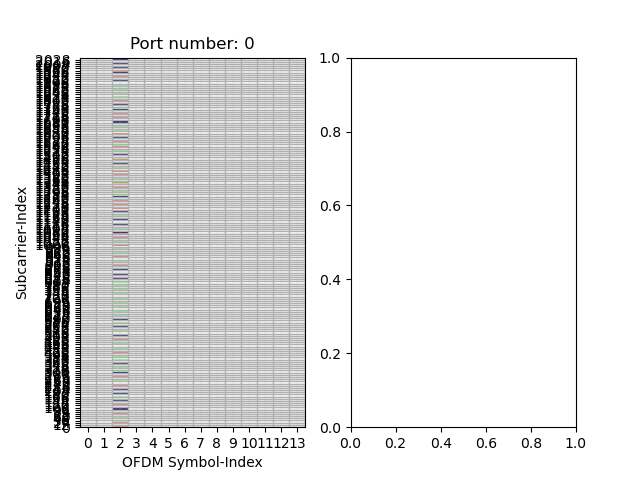

((<Figure size 640x480 with 2 Axes>,
  array([<Axes: title={'center': 'Port number: 0'}, xlabel='OFDM Symbol-Index', ylabel='Subcarrier-Index'>,
         <Axes: >], dtype=object)),
 None)

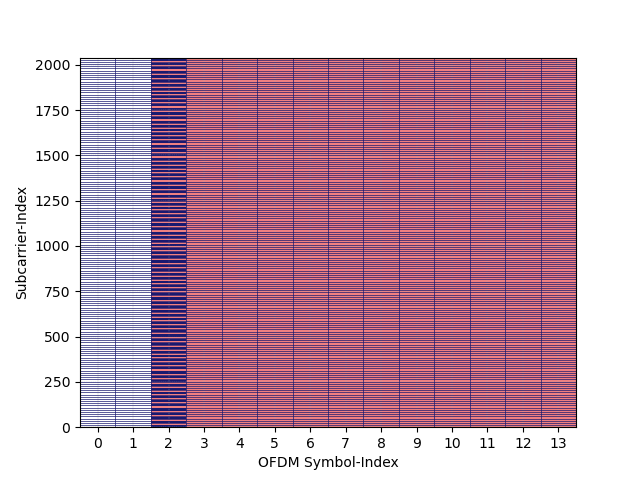

In [5]:

pdschUpperPhy = PDSCHUpperPhy(symbolsPerSlot = numSymbols, numRB = numRB, mcsIndex = mcsIndex, 
                              numlayers = numlayers, scalingField = scalingField, additionalOverhead = additionalOverhead,
                              dmrsREs = dmrsREs, numTBs=numTBs, pdschTable = mcsTable, verbose = False)

codeword      = pdschUpperPhy(tblock = [None, None], rvid = [0, 0], enableLBRM = [False, False], numBatch = numBatches, numBSs = numBSs)

rnti          = np.random.randint(65536, size=numBSs*numBatches)
nID           = np.random.randint(1024,  size=numBSs*numBatches)
bits2         = codeword[1] if numTBs == 2 else None

pdschLowerPhyChain = PDSCHLowerPhy(pdschMappingType, configurationType, dmrsTypeAPosition, 
                                   maxLength, dmrsAdditionalPosition, l0, ld, l1)
resourceGrid  = pdschLowerPhyChain(codeword[0], numRB, rank, slotNumber, scramblingID,
                                   nSCID, rnti, nID, modOrder, startSymbol, bits2 = bits2)

## Load the resource Grid into the transmision Grid
txGrid        = np.zeros(resourceGrid.shape[0:-1]+(Nfft,), dtype= np.complex64)
bwpOffset     = np.int32(0.5*(Nfft-numRB*12))
txGrid[...,bwpOffset:bwpOffset+numRB*12] = np.sqrt(1/rank)*resourceGrid

txGrid        = txGrid/(np.linalg.norm(np.abs(txGrid), axis=-1)[...,np.newaxis] + 0.0001)

pdschLowerPhyChain.displayDMRSGrid(), pdschLowerPhyChain.displayResourceGrid()

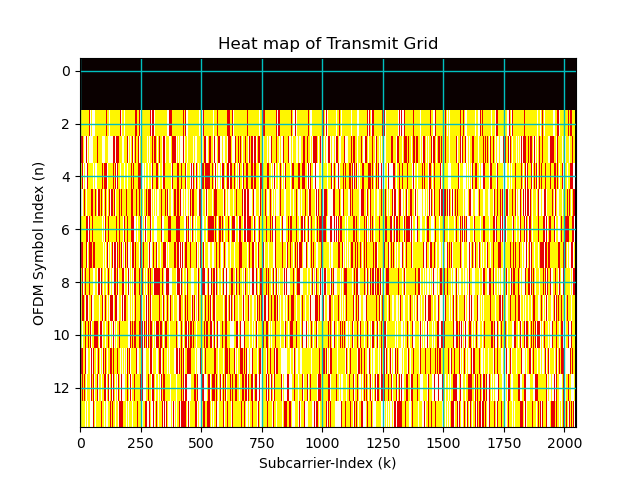

In [6]:
# Plot Resource Grid
#################################################################
fig, ax = plt.subplots()
plt.imshow(np.abs(txGrid[0,0,0]), cmap = 'hot', interpolation='nearest', aspect = "auto")
ax = plt.gca();
ax.grid(color='c', linestyle='-', linewidth=1)
ax.set_xlabel("Subcarrier-Index (k)")
ax.set_ylabel("OFDM Symbol Index (n)")
ax.set_title("Heat map of Transmit Grid")
# Gridlines based on minor ticks
plt.show()

## 9. SSB Transmitter Implementation

![SSB Transmitter](images/PBCH_SDR_Tx.svg)

## 9. Generate the SSB Resource Grid


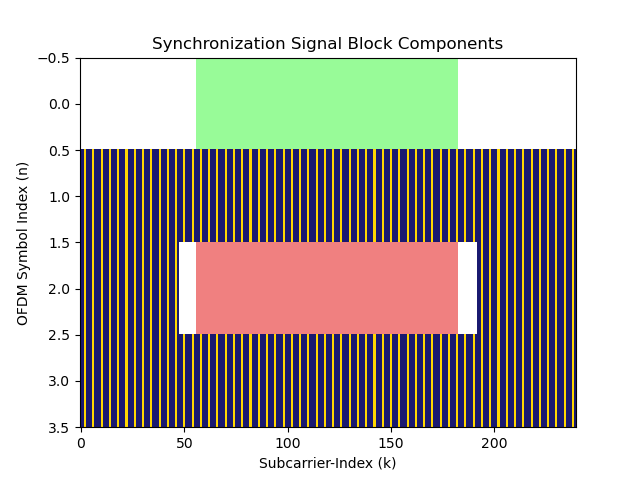

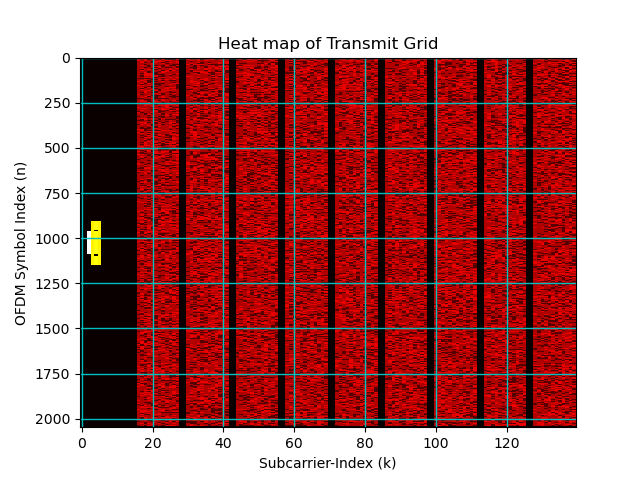

In [7]:
## This class fetches valid set of 5G parameters for the system configurations
nSymbolFrame   = 14
numOFDMSymbols = 14
tfParams    = TimeFrequency5GParameters(bandwidth, scs)
tfParams(nSymbolFrame, typeCP = "normal")
nRB         = tfParams.numRBs        # SSB Grid size (Number of RBs considered for SSB transition)
Neff        = nRB*12
lengthCP    = (tfParams.lengthCP).astype(np.int32)    # CP length
#___________________________________________________________________

#### Generate MIB Information
lamda                           = 3e8/carrierFrequency
nSCSOffset                      = 1
ssbParameters                   = GenerateValidSSBParameters(carrierFrequency, nSCSOffset, "caseA")

systemFrameNumber               = ssbParameters.systemFrameNumber
subCarrierSpacingCommon         = scs
ssbSubCarrierOffset             = ssbParameters.ssbSubCarrierOffset
DMRSTypeAPosition               = ssbParameters.DMRSTypeAPosition
controlResourceSet0             = ssbParameters.controlResourceSet0
searchSpace0                    = ssbParameters.searchSpace0

isPairedBand                    = ssbParameters.isPairedBand
nSCSOffset                      = ssbParameters.nSCSOffset
choiceBit                       = ssbParameters.choiceBit
ssbType                         = ssbParameters.ssbType
nssbCandidatesInHrf             = ssbParameters.nssbCandidatesInHrf
ssbIndex                        = ssbParameters.ssbIndex
hrfBit                          = ssbParameters.hrfBit
cellBarred                      = ssbParameters.cellBarred
intraFrequencyReselection       = ssbParameters.intraFrequencyReselection
withSharedSpectrumChannelAccess = ssbParameters.withSharedSpectrumChannelAccess

Nsc_ssb                         = 240
Nsymb_ssb                       = 4
#_______________________________________


N_ID2        = np.random.randint(3)

# Generate PSS sequence
pssObject    = PSS(N_ID2);
pssSequence  = pssObject()

N_ID1        = np.random.randint(336)
N_ID         = 3*N_ID1 + N_ID2

# Generate SSS sequence
sssObject    = SSS(N_ID1, N_ID2);
sssSequence  = sssObject()

# Generate DMRS sequence
dmrsLen      = 144;
dmrsObject   = DMRS("PBCH", N_ID, ssbIndex, nssbCandidatesInHrf, hrfBit)
# dmrsSeq = dmrs.getSequence("tensorflow")
dmrsSequence = dmrsObject(dmrsLen)


# Generate PBCH symbols
pbchObject   = PBCH(carrierFrequency, choiceBit, subCarrierSpacingCommon, DMRSTypeAPosition,
                   controlResourceSet0, searchSpace0, cellBarred, intraFrequencyReselection,
                   systemFrameNumber, ssbSubCarrierOffset, hrfBit, ssbIndex, N_ID,
                   nssbCandidatesInHrf)

pbchSymbols  = pbchObject()

## Generate SSB Object
ssbObject    = SSB_Grid(N_ID, True)
ssb          = ssbObject(pssSequence, sssSequence, dmrsSequence, pbchSymbols)  # generating SSB using PSS,SSS, PBCH payload and DMRS.   

## Loading SSB to Resource Grid
ssbPositionInBurst    = np.zeros(nssbCandidatesInHrf, dtype=int)
ssbPositionInBurst[0] = 1 

ssbRGobject    = ResourceMapperSSB(ssbType, carrierFrequency, isPairedBand, withSharedSpectrumChannelAccess)

offsetInRBs    = int((nRB-20)/2)
ssbGrid        = ssbRGobject(ssb[0], ssbPositionInBurst, offsetInSubcarriers = ssbSubCarrierOffset,
                      offsetInRBs = offsetInRBs, numRBs = nRB)[0:14]         # SSB Grid of size 14 X numbers of RBs x 12.
fig, ax = ssbObject.displayGrid(option=1)


firstSymbolIndex   = int(2)
numofGuardCarriers = (int((Nfft - Neff)/2), int((Nfft - Neff)/2))
offsetToPointA     = 0
firstSCIndex       = int(numofGuardCarriers[0] + offsetToPointA)

ssbResGrid = np.zeros((numOFDMSymbols, Nfft), dtype= np.complex64)
ssbResGrid[:, firstSCIndex:firstSCIndex+ssbGrid.shape[-1]] = ssbGrid

#__________________________________________________

## Concatenate the SSB and PDSCH Grid
X                 = np.concatenate([ssbResGrid, txGrid[:,0,0].reshape(-1,txGrid.shape[-1])], axis=0)

## OFDM Modulation at Transmitter
#####################################
modulator = OFDMModulator(lengthCP[1])
x_time    = modulator(X).flatten()
#______________________________________________________

# Plot Resource Grid
#################################################################
fig, ax = plt.subplots()
plt.imshow(np.abs(X).T, cmap = 'hot', interpolation='nearest', aspect = "auto")
ax = plt.gca();
ax.grid(color='c', linestyle='-', linewidth=1)
ax.set_xlabel("Subcarrier-Index (k)")
ax.set_ylabel("OFDM Symbol Index (n)")
ax.set_title("Heat map of Transmit Grid")
# Gridlines based on minor ticks
plt.show()

## 9. SDR-Setup Configurations

In [8]:
## SDR Parameters
sample_rate         = Nfft*scs

# Pulse Shaping
numSamplesPerSymbol = 1

# number of samples returned per call to rx()
buffer_size         = int(Nfft*1.2*numSamplesPerSymbol*112) 

# Basic SDR Setup
sdr = adi.Pluto("ip:192.168.2.1")
sdr.sample_rate           = int(sample_rate)

# Config Tx
sdr.tx_rf_bandwidth       = int(60*10**6) # filter cutoff, just set it to the same as sample rate
sdr.tx_lo                 = int(carrierFrequency)
sdr.tx_hardwaregain_chan0 = -10 # Increase to increase tx power, valid range is -90 to 0 dB

# # Config Rx
# sdr.gain_control_mode_chan0 = 'manual'
# sdr.rx_hardwaregain_chan0   = 40.0      # dB
# # The receive gain on the Pluto has a range from 0 to 74.5 dB.

sdr.gain_control_mode_chan0 = 'slow_attack'
# # AGC modes: 
#     # 1. "manual"
#     # 2. "slow_attack"
#     # 3. "fast_attack"

sdr.rx_lo           = int(carrierFrequency)
sdr.rx_rf_bandwidth = int(60*10**6) # filter width, just set it to the same as sample rate for now
sdr.rx_buffer_size  = int(4*buffer_size)

In [9]:
np.abs(1.2*2**17*(x_time.repeat(1))).max(), np.abs(x_time).min()

(12679.488773988369, 0.0)

## 9. Transmission: SDR RF Transmitter

In [10]:

# Start the transmitter
sdr.tx_cyclic_buffer = True  # Enable cyclic buffers
scalingFactor = 1.1*2**18
pulseShaping  = 1
sdr.tx(scalingFactor*x_time) # start transmitting


## 9. Receiver Implementation: SSB
![Receiver_Implementation](images/PBCH_SDR_Rx.svg)

## 9. Reception: SDR RF Receiver

In [11]:

# Clear buffer just to be safe
for i in range (0, 10):
    raw_data = sdr.rx()

# Receive samples
rx_samples = sdr.rx()

# # # Stop transmitting
# sdr.tx_destroy_buffer()


## 9. Time Synchronization: Based on PSS Correlation

**(rasterOffset, PSS-ID) (909, 0)
**(rasterOffset, PSS-ID) (909, 1)
**(rasterOffset, PSS-ID) (909, 2)


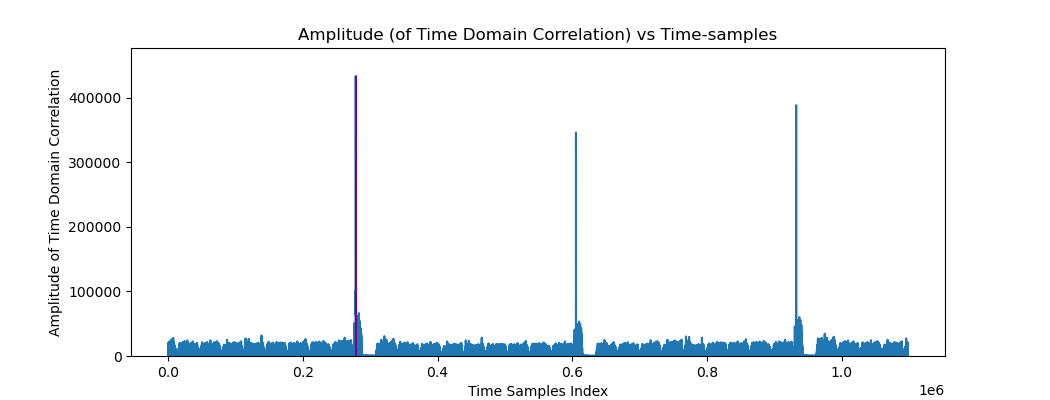

In [12]:
## PSS Detection: Based on time domain PSS Correlation
# pssPeakIndices, pssCorrelation, rN_ID2 = pssDetection(r, Nfft, lengthCP = lengthCP[1],
#                                                       N_ID2 = None, freqOffset = ssboffset,
#                                                       height = 0.75, prominence = 0.65, width=10)
## PSS Detection: Based on time domain PSS Correlation
# pssDetection   = PSSDetection("correlation", "threshold")
pssDetection   = PSSDetection("largestPeak")
ssboffset      = int((Nfft-Neff)/2+ssbRGobject.startingSubcarrierIndices)
pssPeakIndices, pssCorrelation, rN_ID2, freqOffset = pssDetection(rx_samples, Nfft, lengthCP = lengthCP[1],
                                                                  nID2 = None, freqOffset = ssboffset)

## PSS Detection Plot
#################################################################
fig, ax = plt.subplots(figsize = (10.5, 4))

# single line
ax.plot(pssCorrelation)
ax.vlines(x = pssPeakIndices, ymin = 0*pssCorrelation[pssPeakIndices],
           ymax = pssCorrelation[pssPeakIndices], colors = 'purple')
ax.set_ylim([0,np.max(pssCorrelation)*1.1])
ax.set_xlabel("Time Samples Index")
ax.set_ylabel("Amplitude of Time Domain Correlation")
ax.set_title("Amplitude (of Time Domain Correlation) vs Time-samples")
plt.show()
#________________________________________________________________

## 9. PBCH Receiver

1. OFDM Demodulation
2. SSS Dtection
3. DMRS Parameters Detection
4. Channel Estimation and PBCH Equalization
4. PBCH Decoding and MIB Extraction

In [13]:
## OFDM Demodulator Object
ofdmDemodulator = OFDMDemodulator(Nfft, lengthCP[1])
pssStartIndex   = pssPeakIndices
# pssStartIndex   = pssPeakIndices[0][0]
rxGrid          = ofdmDemodulator((rx_samples.reshape(1,-1))[...,pssStartIndex:(pssStartIndex+4*(Nfft+lengthCP[1]))])

ssbSCSoffset    = int((Nfft-Neff)/2+ssbRGobject.startingSubcarrierIndices)
ssbEstimate     = rxGrid[:,:,ssbSCSoffset:(ssbSCSoffset+240)]

nssbCandidatesInHrf = 4
dmrsLen             = 144
## N_ID_1 Estimation: SSS based
sssDetection   = SSSDetection(method="channelAssisted", nID2=rN_ID2)
rN_ID1         = sssDetection(ssbEstimate[0])
rN_ID          = 3*rN_ID1 + rN_ID2

## Generate SSB object to get DMRS and PBCH Indices
rxSSBobject    = SSB_Grid(rN_ID)
rxDMRSIndices  = rxSSBobject.dmrsIndices

## Generate DMRS sequence
dmrsDetection  = DMRSParameterDetection(int(rN_ID), nssbCandidatesInHrf)
rssbIndex, rHrfBit = dmrsDetection(ssbEstimate[0])
rxDMRSobject   = DMRS("PBCH", int(rN_ID), int(rssbIndex), nssbCandidatesInHrf, rHrfBit)
rxDMRSseq      = rxDMRSobject(dmrsLen)

# ## Estimating the channel at DMRS (t-f) location, interpolting for data (t-f) location and equalizing the symbols
# ## Object for Channel Estimation
# chanEst        = ChannelEstimationAndEqualization(estimatorType = "ZF", interpolatorType = "NN")
# rxPBCHIndices  = rxSSBobject.pbchIndices
# pbchEstimate   = chanEst(ssbEstimate, rxDMRSseq, rxDMRSIndices, rxPBCHIndices, 10)

chanEst        = ChannelEstimationAndEqualizationPBCH(estimatorType = "ZF", interpolatorType = "Linear", isUEmobile=True)
pbchEstimate   = chanEst(ssbEstimate, rxDMRSseq, rN_ID)

## PBCH Chain for Decoding information
polarDecoder    = "SCL"
symbolDemapper  = "maxlog"
# extractMIBinfo = False
extractMIBinfo  = True
# carrierFreq, cellID, nssbCandidatesInHrf, ssbIndex, polarDecType, symbolDemapperType
pbchDecoder     = PBCHDecoder(carrierFrequency, int(rN_ID), nssbCandidatesInHrf, rssbIndex, polarDecoder, symbolDemapper)
rxMIB, check    = pbchDecoder(pbchEstimate, 10, extractMIBinfo)

<frozen toolkit5G.ChannelCoder.PolarCoder.polarDecoder>:494: UserWarning: Required ressource allocation is large for the selected blocklength. Consider option `cpu_only=True`.


## 9. SSB Grid: Transmitter and Receiver

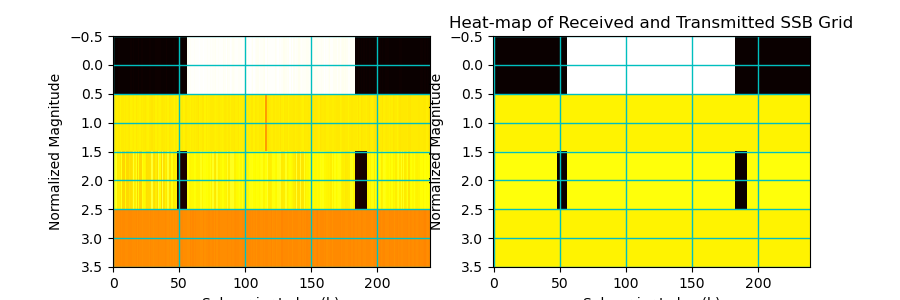

In [14]:
# Plot SSB
fig, ax = plt.subplots(1,2, figsize = (9,3))
ax[0].imshow(np.abs(ssbEstimate[0]), cmap = 'hot', interpolation='nearest', aspect = "auto")
ax[0].grid(color='c', linestyle='-', linewidth=1)
ax[0].set_xlabel("Subcarrier-Index (k)")
ax[0].set_ylabel("Normalized Magnitude")

ax[1].imshow(np.abs(ssb[0]), cmap = 'hot', interpolation='nearest', aspect = "auto")
ax[1].grid(color='c', linestyle='-', linewidth=1)
ax[1].set_xlabel("Subcarrier-Index (k)")
ax[1].set_ylabel("Normalized Magnitude")
plt.title("Heat-map of Received and Transmitted SSB Grid")

plt.show()

## 9. Spectrum: Transmitted Grid and Received Grid

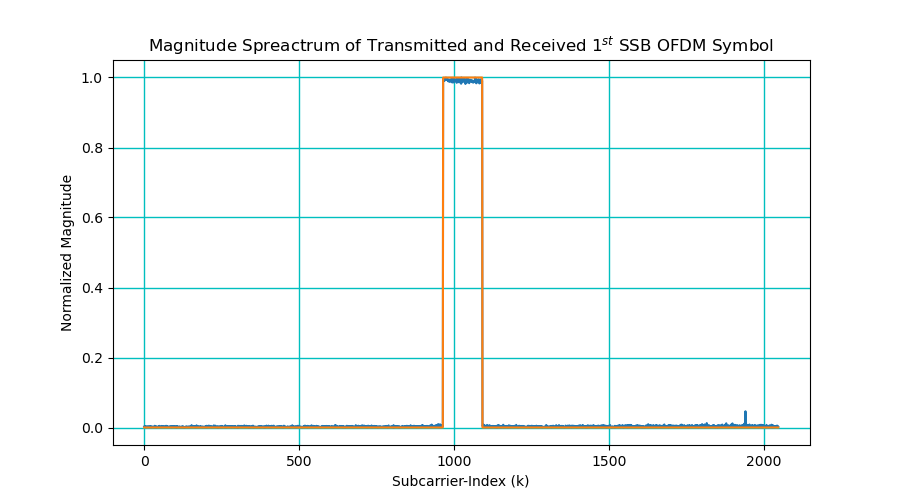

In [15]:
# Plot SSB
fig, ax = plt.subplots(figsize = (9,5))
ax.plot(np.abs(rxGrid[0][0])/np.abs(rxGrid[0][0]).max())
ax.plot(np.abs(X[2])/np.abs(X[2]).max())
ax.grid(color='c', linestyle='-', linewidth=1)
ax.set_xlabel("Subcarrier-Index (k)")
ax.set_ylabel("Normalized Magnitude")
ax.set_title("Magnitude Spreactrum of Transmitted and Received $1^{st}$ SSB OFDM Symbol")
plt.show()

## 9. PBCH Decoding and Constellation

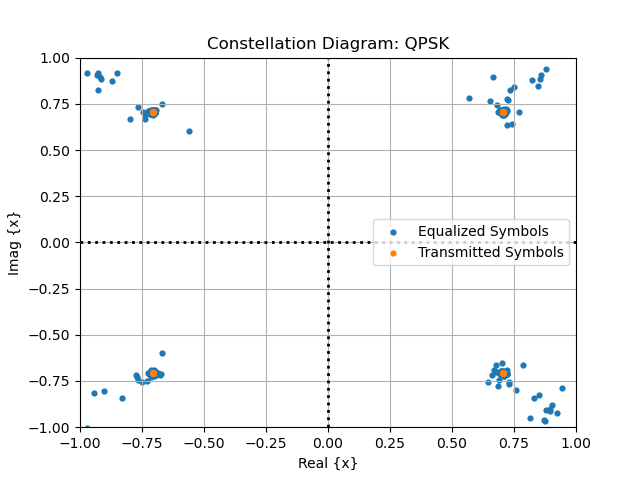

In [16]:
fig, ax = plt.subplots()
ax.scatter(np.real(pbchEstimate), np.imag(pbchEstimate), s = 12, label = "Equalized Symbols")
ax.scatter(np.real(pbchSymbols), np.imag(pbchSymbols), s = 12, label = "Transmitted Symbols")
ax.grid()
ax.axhline(y=0, ls=":", c="k", lw = 2); ax.axvline(x=0, ls=":", c="k", lw = 2)
ax.set_xlim([-1,1]); ax.set_ylim([-1,1])
ax.set_xlabel("Real {x}"); ax.set_ylabel("Imag {x}")
ax.set_title("Constellation Diagram: QPSK")
ax.legend(loc = "best")
plt.show()

In [17]:
pbchDecoder.mibRx.displayParameters(0)

Carrier Frequency:	1000000000
ChoiceBit:  		0
nSsbCandidatesInHrf: 	4
subCarrierSpacingCommon:15000
DMRSTypeAPosition: 	typeA
controlResourceSet0:	15
searchSpace0: 		6
cellBarred: 		barred
intraFreqReselection: 	notAllowed
systemFrameNumber: 	66
ssbSubCarrierOffset: 	1
HRFBit: 		0
iSSBindex: 		0


In [18]:
pbchObject.mib.displayParameters(0)

Carrier Frequency:	1000000000
ChoiceBit:  		0
nSsbCandidatesInHrf: 	4
subCarrierSpacingCommon:15000
DMRSTypeAPosition: 	typeA
controlResourceSet0:	2
searchSpace0: 		14
cellBarred: 		notBarred
intraFreqReselection: 	allowed
systemFrameNumber: 	795
ssbSubCarrierOffset: 	5
HRFBit: 		0
iSSBindex: 		0


## 9. Performance Verification

In [19]:
if (rN_ID == N_ID):
    print("[Success]: Cell-IDs correctly detected!")
else:
    if (rN_ID1 != N_ID1 and rN_ID2 != N_ID2):
        print("[Failed]: Receiver couldn't detect the Cell-ID1 and cell-ID2 correctly!")
    elif(rN_ID1 != N_ID1):
        print("[Failed]: Receiver couldn't detect the Cell-ID1 correctly!")
    else:
        print("[Failed]: Receiver couldn't detect the cell-ID2 correctly!")
        
if (rssbIndex == ssbIndex[0]):
    print("[Success]: DMRS parameters correctly detected!")
else:
    print("[Failed]: Receiver couldn't detect the ssbIndex correctly!")
    
## Computing BER: Coded and Uncoded
numUEs = 1
nBatch = 1
uncodedBER     = np.zeros((numUEs, nBatch))
codedBER       = np.zeros((numUEs, nBatch))

bitEst         = pbchDecoder.llr.copy()
bitEst[pbchDecoder.llr  > 0]   = 1
bitEst[pbchDecoder.llr  < 0]   = 0
uncodedBER = np.mean(np.abs(bitEst - pbchObject.scr2bits[0]))
codedBER   = np.mean(np.abs(pbchDecoder.pbchDeInterleavedBits - pbchObject.mibSequence[0]))

print(" (uncoded-BER, codedBER): "+str((uncodedBER, codedBER)))

[Success]: Cell-IDs correctly detected!
[Success]: DMRS parameters correctly detected!
 (uncoded-BER, codedBER): (0.0, 0.4375)


## 9. PDSCH Receiver Implementation
### 9. Extract PDSCH Resource Grid

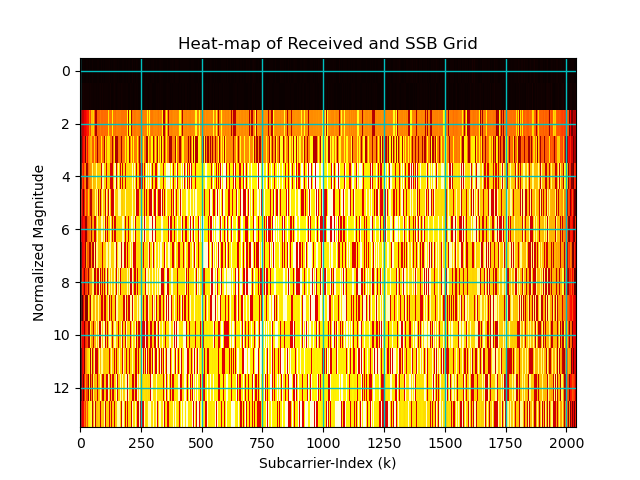

In [20]:
## OFDM Demodulator Object
ofdmDemodulator = OFDMDemodulator(Nfft, lengthCP[1])
pdschStartIndex = pssStartIndex+12*(Nfft+lengthCP[1])
# pssStartIndex   = pssPeakIndices[0][0]
rxGrid          = ofdmDemodulator((rx_samples.reshape(1,-1))[...,pdschStartIndex:(pdschStartIndex+14*numBatches*(Nfft+lengthCP[1]))])

pdschGrid       = rxGrid[:,:,bwpOffset:bwpOffset+numRB*12].reshape(numBatches,1,14,-1)

# Plot SSB
fig, ax = plt.subplots()
plt.imshow(np.abs(pdschGrid[0,0]), cmap = 'hot', interpolation='nearest', aspect = "auto")
ax = plt.gca();
ax.grid(color='c', linestyle='-', linewidth=1)
ax.set_xlabel("Subcarrier-Index (k)")
ax.set_ylabel("Normalized Magnitude")
ax.set_title("Heat-map of Received and SSB Grid")
plt.show()

In [21]:
pdschGrid.shape

(9, 1, 14, 2040)

### 9. PDSCH Receiver

![PDSCH Receiver](images/PDSCH_Rx.png)

In [22]:
# Channel Estimation and Equalization
chEst = ChannelEstimationAndEqualizationPDSCH(slotNumber, scramblingID, nSCID, rnti, nID, 
                                              pdschMappingType, configurationType, dmrsTypeAPosition, 
                                              maxLength, dmrsAdditionalPosition, l0, ld, l1, 
                                              startSymbol, numTargetBits, modOrder)
interpolator = "linear" # Can be "nearest" | "linear" | "cubicspline"
polyOrder    = 3 # Required only for Spline, Will be ignored for other interpolators
rsymbols     = chEst(pdschGrid, interpolator)

#### Layer Demapping
layDemap     = LayerDemapper(numTBs, rank)
rlmSym       = layDemap(rsymbols)  # received symbols

######## Demapping.
demapMethod  = "app" # Demapping method
constType    = "qam"  # Symbol mapping type
modOrder     = modOrder       # Mordulation order or number of bits per symbol
snr          = 10
hard_out     = False
demapper     = Demapper(demapMethod, constType, modOrder, hard_out = hard_out)

## Computed Received bits
rxLLRs      = demapper([np.complex64(rlmSym), 1/snr])

## Descrambling
if hard_out:
    
    scrObject = Scrambler("PDSCH", rnti, 0, nID)
    rxBits    = scrObject(rxLLRs)

else:
    scrObject = DeScrambler("PDSCH", rnti, 0, nID)
    rscrBits  = scrObject(rxLLRs)
    rxBits    = np.where(rscrBits>0, 1, 0)

# PDSCH Upper Physical layer Decoder
pdschUpPhyDec = PDSCHDecoderUpperPhy(numTBs = numTBs, mcsIndex = mcsIndex, symbolsPerSlot= numSymbols, 
                                     numRB  = numRB, numLayers = numlayers, scalingField = scalingField, 
                                     additionalOverhead = additionalOverhead, dmrsREs = dmrsREs, 
                                     enableLBRM = [False, False], pdschTable = mcsTable, rvid = [0, 0], verbose=False)
rbits         = pdschUpPhyDec([rscrBits])

### 9. Constellation Diagram

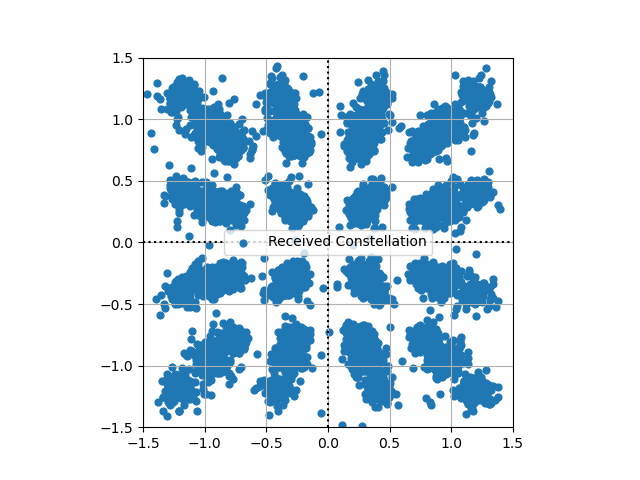

In [23]:
fig, ax = plt.subplots()
ax.set_aspect(True)
ax.scatter(np.real(rsymbols), 
           np.imag(rsymbols), s=24, label="Received Constellation")
# equalizedSamples = rsymbols.flatten()
# indices = np.random.choice(equalizedSamples.size, size = 10000, replace = False)
# ax.scatter(np.real(equalizedSamples[indices]), 
#            np.imag(equalizedSamples[indices]), s=24, label="Received Constellation")
ax.axhline(y=0, ls=":", c="k"); ax.axvline(x=0, ls=":", c="k")
ax.set_xlim([-1.5,1.5]); ax.set_ylim([-1.5,1.5])
# ax.set_xlim([-2,2]); ax.set_ylim([-2,2])
# ax.set_xlabel("Real {x}"); ax.set_ylabel("Imag {x}")
# if modOrder ==2:
#     ax.set_title("Constellation Diagram: QPSK")
# else:
#     ax.set_title("Constellation Diagram: "+str(pow(2,modOrder))+str(" QAM"))

ax.grid(); 
ax.legend(loc = "best")
plt.show()

## 9. Key Performance Indicators

1. Data-rate Indicators
    - Thoughput (Bits per seconds)
    - Spectral Efficency (Bits per second per Hertz)
2. Reliability
    - Block Error Rate (BLER)
    - Bit Error Rate (BER)

In [24]:
# Reliability Metrics
codedBER          = np.mean(np.abs(rbits[0][:,np.newaxis]-pdschUpperPhy.tblock1))
uncodedBER        = np.mean(np.abs(codeword[0][:,0,:] - rxBits))
bler              = 1-np.mean(pdschUpPhyDec.crcCheckTBs)

# Data rate Metrics
maxThroughput = (14*numRB*12)*modOrder*codeRate*1000*15000/scs
slotDuration      = 10**(-3)*15000/(scs)
throughput        = (1-bler)*numBatches*pdschUpperPhy.tbLen1/(slotDuration*(numBatches+1))
spectalEfficiency = throughput/bandwidth

print()
print("         Throughput: "+str(throughput/10**6)+" Mbps")
print("Spectral Efficiency: "+str(spectalEfficiency)+" bits per second per Hz")
print()
print("*********************** Reliability ***********************")
print("   Block Error Rate: "+str(bler))
print("     Bit Error Rate: "+str(codedBER))
print()



         Throughput: 50.7312 Mbps
Spectral Efficiency: 1.69104 bits per second per Hz

*********************** Reliability ***********************
   Block Error Rate: 0.0
     Bit Error Rate: 0.0



## Quasi-realtime simulation

In [25]:
# # function that draws each frame of the animation
# numSamples   = Nfft + lengthCP[1]

# #
# pssDetection = PSSDetection("largestPeak")
# ssboffset    = int((Nfft-Neff)/2+ssbRGobject.startingSubcarrierIndices)

# # Channel Estimation and Equalization
# chEst = ChannelEstimationAndEqualizationPDSCH(slotNumber, scramblingID, nSCID, rnti, nID, 
#                                               pdschMappingType, configurationType, dmrsTypeAPosition, 
#                                               maxLength, dmrsAdditionalPosition, l0, ld, l1, 
#                                               startSymbol, numTargetBits, modOrder)

# def animate(i):
#     # Receive samples
#     rx_samples = sdr.rx()

#     pssPeakIndices, pssCorrelation, rN_ID2, freqOffset = pssDetection(rx_samples, Nfft, lengthCP = lengthCP[1],
#                                                                   nID2=None, freqOffset = ssboffset)


#     if(pssPeakIndices > rx_samples.size - 140*(Nfft + lengthCP[1])):
#         pssPeakIndices = pssPeakIndices - 140*(Nfft + lengthCP[1])

#     # CFO estimation
#     obj    = CarrierFrequencyOffsetEstimation(Nfft,lengthCP[1])
#     cfoEst = obj(rx_samples[pssPeakIndices: pssPeakIndices + numSamples],numCFOIteration = 2)  # Computed CFO

#     ## OFDM Demodulator Object
#     ofdmDemodulator = OFDMDemodulator(Nfft, lengthCP[1])
#     pdschStartIndex = pssPeakIndices + 12*(Nfft+lengthCP[1])
#     rxGrid          = ofdmDemodulator((rx_samples.reshape(1,-1))[...,pdschStartIndex:(pdschStartIndex+14*numBatches*(Nfft+lengthCP[1]))])

#     pdschGrid       = rxGrid[:,:,bwpOffset:bwpOffset+numRB*12].reshape(numBatches,1,14,-1)

#     interpolator = "linear" # Can be "nearest" | "linear" | "cubicspline"
#     polyOrder    = 3 # Required only for Spline, Will be ignored for other interpolators
#     rsymbols     = chEst(pdschGrid, interpolator)

#     #### Layer Demapping
#     layDemap     = LayerDemapper(numTBs, rank)
#     rlmSym       = layDemap(rsymbols)  # received symbols

#     ######## Demapping.
#     demapMethod  = "app" # Demapping method
#     constType    = "qam"  # Symbol mapping type
#     snr          = 10
#     hard_out     = False
#     demapper     = Demapper(demapMethod, constType, modOrder, hard_out = hard_out)

#     ## Computed Received bits
#     rxLLRs      = demapper([np.complex64(rlmSym), 1/snr])

#     ## Descrambling
#     if hard_out:

#         scrObject = Scrambler("PDSCH", rnti, 0, nID)
#         rxBits    = scrObject(rxLLRs)

#     else:
#         scrObject = DeScrambler("PDSCH", rnti, 0, nID)
#         rscrBits  = scrObject(rxLLRs)
#         rxBits    = np.where(rscrBits>0, 1, 0)

#     # PDSCH Upper Physical layer Decoder
#     pdschUpPhyDec = PDSCHDecoderUpperPhy(numTBs = numTBs, mcsIndex = mcsIndex, symbolsPerSlot= numSymbols, 
#                                          numRB  = numRB, numLayers = numlayers, scalingField = scalingField, 
#                                          additionalOverhead = additionalOverhead, dmrsREs = dmrsREs, 
#                                          enableLBRM = [False, False], pdschTable = mcsTable, rvid = [0, 0], verbose=False)
#     rbits         = pdschUpPhyDec([rscrBits])
    
#     # Reliability Metrics
#     codedBER          = np.mean(np.abs(rbits[0][:,np.newaxis]-pdschUpperPhy.tblock1))
#     uncodedBER        = np.mean(np.abs(codeword[0][:,0,:] - rxBits))
#     bler              = 1-np.mean(pdschUpPhyDec.crcCheckTBs)

#     # Data rate Metrics
#     slotDuration      = 10**(-3)*15000/(scs)
#     throughput        = (1-bler)*numBatches*pdschUpperPhy.tbLen1/(slotDuration*(numBatches+1))
#     spectalEfficiency = throughput/bandwidth
    
#     ax[0].clear()
#     ax[0].set_xlim([-1.5, 1.5])
#     ax[0].set_ylim([-1.5, 1.5])
#     ax[0].scatter(np.real(rsymbols.flatten()), np.imag(rsymbols.flatten()), s=24, label="Received Constellation")
    
# #     indices = np.random.choice(rsymbols.size, size = 10000, replace = False)
# #     equalizedSamples = rsymbols.flatten()[indices]
# #     ax[0].scatter(np.real(equalizedSamples), np.imag(equalizedSamples), s=24, label="Received Constellation")
#     ax[0].axhline(y=0, ls=":", c="k"); 
#     ax[0].axvline(x=0, ls=":", c="k")
    
#     ax[0].set_xlabel("Real {x}"); ax[0].set_ylabel("Imag {x}")
#     if modOrder ==2:
#         ax[0].set_title("Constellation Diagram: QPSK")
#     else:
#         ax[0].set_title("Constellation Diagram: "+str(pow(2,modOrder))+str(" QAM"))

#     ax[0].grid()
#     ax[0].legend(loc = "best")
    
#     # Reliability Metrics
#     codedBER          = np.mean(np.abs(rbits[0][:,np.newaxis]-pdschUpperPhy.tblock1))
#     uncodedBER        = np.mean(np.abs(codeword[0][:,0,:] - rxBits))
#     bler              = 1-np.mean(pdschUpPhyDec.crcCheckTBs)

#     # Data rate Metrics
#     slotDuration      = 10**(-3)*15000/(scs)
#     throughput        = (1-bler)*numBatches*pdschUpperPhy.tbLen1/(slotDuration*(numBatches+1))
#     spectalEfficiency = throughput/bandwidth
    
#     data[0] = throughput/maxThroughput
#     data[1] = 1 - data[0]
#     ax[1].pie(data, wedgeprops=dict(width=0.33, edgecolor='r'), startangle=90, colors = colors[0:2])
#     ax[1].set_title("Throughput Performance")
    
#     data[0] = bler
#     data[1] = 1-bler
#     ax[2].pie(data, wedgeprops=dict(width=0.33, edgecolor='k'), startangle=90, colors = colors[2:4])
#     ax[2].set_title("BLER Performance")

# # Plot SSB
# fig, ax = plt.subplots(1,3, figsize=(10, 3.3), subplot_kw=dict(aspect="equal"))
# ax[0].set_aspect(True)
# ax[1].set_aspect(True)
# ax[2].set_aspect(True)

# scale = 100
# maxThroughput = (14*numRB*12)*modOrder*codeRate*1000*15000/scs
# data    = [0.75,0.25]

# cmap    = plt.get_cmap("tab20c")
# colors  = cmap(np.arange(4)*3)
# #####################
# # run the animation
# #####################
# # frames= 20 means 20 times the animation function is called.
# # interval=500 means 500 milliseconds between each frame.
# # repeat=False means that after all the frames are drawn, the animation will not repeat.
# # Note: plt.show() line is always called after the FuncAnimation line.


# anim = animation.FuncAnimation(fig, animate, frames=1000, interval=1, repeat=False, blit=True)
# # saving to mp4 using ffmpeg writer
# plt.show()

# anim.save("PDSCH_Constellation.gif", fps = 10)

# # writervideo = animation.FFMpegWriter(fps=60)
# # anim.save('Overall.mp4', writer=writervideo)

![PDSCH_Constellation](PDSCH_Constellation.gif)